# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
import xgboost
import time
from joblib import dump, load
import os
import numpy as np

# Load the data

In [3]:
df = pd.read_csv('data_to_ml.csv')

In [6]:
df.columns

Index(['minute', 'position_name', 'shot_body_part_name', 'shot_technique_name',
       'shot_type_name', 'shot_first_time', 'shot_one_on_one',
       'shot_aerial_won', 'shot_deflected', 'shot_open_goal',
       'shot_follows_dribble', 'shot_redirect', 'team_id', 'team_name',
       'under_pressure', 'player_id', 'player_name', 'x1', 'y1', 'x1_end',
       'y1_end', 'number_of_players_opponents', 'number_of_players_teammates',
       'is_goal', 'angle_end', 'distance_end', 'angle', 'distance',
       'x_player_opponent_Goalkeeper', 'x_player_opponent_8',
       'x_player_opponent_1', 'x_player_opponent_2', 'x_player_opponent_3',
       'x_player_teammate_1', 'x_player_opponent_4', 'x_player_opponent_5',
       'x_player_opponent_6', 'x_player_teammate_2', 'x_player_opponent_9',
       'x_player_opponent_10', 'x_player_opponent_11', 'x_player_teammate_3',
       'x_player_teammate_4', 'x_player_teammate_5', 'x_player_teammate_6',
       'x_player_teammate_7', 'x_player_teammate_8', 'x_p

In [4]:
df.describe()

,minute,team_id,player_id,x1,y1,x1_end,y1_end,number_of_players_opponents,number_of_players_teammates,is_goal,...,y_player_teammate_5,y_player_teammate_6,y_player_teammate_7,y_player_teammate_8,y_player_teammate_9,y_player_teammate_10,x_player_opponent_7,y_player_opponent_7,x_player_teammate_Goalkeeper,y_player_teammate_Goalkeeper
count,82821.000000,82821.000000,82821.000000,82821.000000,82821.000000,82821.000000,82821.000000,82821.000000,82821.00000,82821.000000,...,35830.00000,24271.000000,13621.000000,5131.000000,1032.000000,7.000000,61188.000000,61188.000000,68.000000,68.000000
mean,48.870166,684.140653,22921.888337,15.037751,36.797164,4.045968,36.583479,8.348160,4.33640,0.110805,...,44.63964,45.164876,45.640232,46.386981,46.821899,45.914286,24.519045,43.548673,21.563235,40.911765
std,27.036660,1521.128100,58153.427324,8.041376,9.065322,6.134584,6.454478,2.137898,1.92583,0.313893,...,11.81691,12.413972,12.928117,14.011853,13.188958,16.308120,8.473638,9.817286,6.581950,8.313674
min,0.000000,1.000000,2935.000000,-0.500000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,6.80000,6.800000,6.800000,7.300000,6.800000,21.300000,10.300000,7.000000,11.200000,21.500000
25%,26.000000,165.000000,5203.000000,8.600000,30.200000,0.000000,33.100000,7.000000,3.00000,0.000000,...,37.80000,37.800000,38.100000,38.400000,40.400000,43.000000,18.500000,38.200000,16.875000,37.000000
50%,49.000000,217.000000,7113.000000,13.700000,36.600000,0.900000,36.600000,9.000000,4.00000,0.000000,...,44.40000,44.900000,45.200000,45.600000,45.400000,43.800000,23.900000,43.700000,21.200000,41.850000
75%,72.000000,780.000000,16532.000000,20.800000,43.500000,5.900000,40.100000,10.000000,6.00000,0.000000,...,51.70000,52.500000,53.100000,54.600000,54.400000,46.750000,29.000000,49.100000,26.700000,45.800000
max,139.000000,17469.000000,403292.000000,81.600000,72.900000,48.900000,73.100000,11.000000,10.00000,1.000000,...,79.90000,79.900000,79.900000,79.900000,79.800000,76.800000,104.500000,79.600000,35.900000,60.400000


# Data preparation

In [5]:
from sklearn.preprocessing import OrdinalEncoder
#  Encode categorical features using OrdinalEncoder
enc = OrdinalEncoder()

# Transform basic categorical columns
cat_cols = ['position_name', 
           'shot_technique_name', 
           'shot_type_name', 
           'shot_body_part_name']

df[cat_cols] = enc.fit_transform(df[cat_cols])

# Convert encoded columns + minute to int
cols_to_int = ['minute'] + cat_cols
df[cols_to_int] = df[cols_to_int].astype(int)

# Set categorical dtypes for all categorical features
categorical_columns = [
   'position_name',
   'shot_technique_name', 
   'shot_type_name',
   'number_of_players_opponents',
   'number_of_players_teammates',
   'shot_body_part_name',
   'team_name',
   'player_name'
]

df[categorical_columns] = df[categorical_columns].astype('category')

# Preview data
df.head()

,minute,position_name,shot_body_part_name,shot_technique_name,shot_type_name,shot_first_time,shot_one_on_one,shot_aerial_won,shot_deflected,shot_open_goal,...,y_player_teammate_6,y_player_teammate_7,y_player_teammate_8,y_player_teammate_9,y_player_teammate_10,x_player_opponent_7,y_player_opponent_7,x_player_teammate_Goalkeeper,y_player_teammate_Goalkeeper,shot_kick_off
0,0,18,3,4,3,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,5,18,1,4,3,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,5,4,3,2,3,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,5,10,3,4,3,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,5,17,1,4,3,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [49]:
########### OUTDATED ############

# dump(enc,'labelEncoder.joblib')
# enc2 = load('labelEncoder.joblib')
# df[['position_name', 
#     'shot_technique_name', 
#     'shot_type_name', 
#     'shot_body_part_name']] = enc2.inverse_transform(df[['position_name', 
#     'shot_technique_name', 
#     'shot_type_name',
#     'shot_body_part_name']])

# df[['position_name', 
#     'shot_technique_name', 
#     'shot_type_name', 
#     'shot_body_part_name']] = enc2.transform(df[['position_name', 
#     'shot_technique_name', 
#     'shot_type_name', 
#     'shot_body_part_name']])

# enc.inverse_transform(df[['position_name', 
#     'shot_technique_name', 
#     'shot_type_name',
#     'shot_body_part_name']])

# ############### NEW ################
# from sklearn.preprocessing import LabelEncoder

# le_posiotion_name = LabelEncoder()
# le_shot_technique_name = LabelEncoder()
# le_shot_type_name = LabelEncoder()
# le_shot_body_part_name = LabelEncoder()

# df['position_name'] = le_posiotion_name.fit_transform(df['position_name'])
# df['shot_technique_name'] = le_shot_technique_name.fit_transform(df['shot_technique_name'])
# df['shot_type_name'] = le_shot_type_name.fit_transform(df['shot_type_name'])
# df['shot_body_part_name'] = le_shot_body_part_name.fit_transform(df['shot_body_part_name'])

In [6]:
# Assuming your data is in a DataFrame named df
# If you haven't loaded data yet, e.g.:
# df = pd.read_csv('path/to/your_data.csv')

# 1. Select only numeric columns (for correlation calculation)
numeric_df = df.select_dtypes(include=[np.number])

# 2. Calculate correlation matrix
corr_matrix = numeric_df.corr()

# 3. Visualize full correlation matrix using heatmap
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
# plt.title("Correlation Matrix")
# plt.show()

# 4. Extract highly correlated feature pairs
# Set threshold - here we use 0.7 (can be adjusted)
threshold = 0.7

# To avoid duplicates (matrix is symmetric) and exclude self-correlation,
# select only upper triangle:
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Transform matrix to "long" format
corr_pairs = upper_tri.stack().reset_index()
corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Filter pairs that meet high correlation condition (based on absolute value)
high_corr = corr_pairs[np.abs(corr_pairs['Correlation']) >= threshold].sort_values(by='Correlation', ascending=False)

print(f"Feature pairs with high correlation (|correlation| >= {threshold}):")
print(high_corr)

Feature pairs with high correlation (|correlation| >= 0.7):
                         Feature 1                     Feature 2  Correlation
1272           x_player_teammate_7  y_player_teammate_Goalkeeper     0.969803
175                             x1                      distance     0.926222
1537           y_player_teammate_2          y_player_teammate_10     0.914141
1300           x_player_teammate_9          x_player_teammate_10     0.887253
884            x_player_opponent_4          x_player_teammate_10     0.873471
1635          y_player_teammate_10           x_player_opponent_7     0.848431
722            x_player_opponent_1          x_player_teammate_10     0.819805
980            x_player_opponent_6          y_player_teammate_10     0.804361
1097          x_player_opponent_11          x_player_teammate_10     0.800039
590                       distance          x_player_teammate_10     0.791089
278                         x1_end                  distance_end     0.787374
764 

In [7]:
# Columns to remove
cols_to_remove = ['x1', 'y1', 'x1_end', 'y1_end', 'distance_end', 'angle_end',
                'team_name', 'player_name', 'team_id', 'player_id', 'minute',
                'shot_deflected', 'shot_redirect']

# Append any columns that start with the specified patterns
cols_to_remove += [col for col in df.columns if col.startswith('x_player_opponent_')]
cols_to_remove += [col for col in df.columns if col.startswith('y_player_opponent_')]
cols_to_remove += [col for col in df.columns if col.startswith('x_player_teammate_')]
cols_to_remove += [col for col in df.columns if col.startswith('y_player_teammate_')]

# Prepare target variable (y)
y = pd.DataFrame(df['is_goal'])

# Prepare feature set (X) - remove is_goal and specified columns
X = df.drop(columns=['is_goal'] + cols_to_remove, axis=1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state=1
)

# Create cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [8]:
count_class_0, count_class_1 = y_train.value_counts()

# Display the count of shots attempted in the training set
print('Shots attempted in the training set:', count_class_0)

# Display the count of successful goals in the training set
print('Goals scored in the training set:', count_class_1)

Shots attempted in the training set: 58895
Goals scored in the training set: 7361


In [9]:
# Class imbalance in training data
scale_pos_weight = count_class_0 / count_class_1
print(f' Class imbalance in training data: {scale_pos_weight:.3f}')

 Class imbalance in training data: 8.001


# Training XGBoost model 

In [91]:
########### GRID SEARCH ################

# Define the xgboost model
xgb_model = xgboost.XGBClassifier(enable_categorical=True, tree_method='hist', objective='binary:logistic')

# Defining the hyper-parameter grid for XG Boost
param_grid_xgb = {'learning_rate': [0.01, 0.001, 0.0001],
              'max_depth': [3, 5, 7, 8, 9],
              'n_estimators': [100, 150, 200, 250, 300],
              'scale_pos_weight': [1, scale_pos_weight]}

# Starting the timer
start_time = time.time()

# Perform grid search with cross-validation
grid_xg = GridSearchCV(xgb_model, param_grid=param_grid_xgb, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the best model on the entire training set
grid_xg.fit(X_train, y_train)

# Take the best parameters for xgboost model
xgb_model = grid_xg.best_estimator_

# Stopping the timer
stop_time = time.time()

# Training Time
xgb_training_time = stop_time - start_time

# Print the best parameters and training time
print("Best parameters: ", grid_xg.best_params_)
print (f"Model Training Time: {xgb_training_time:.3f} seconds")

Best parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 1}
Model Training Time: 1723.158 seconds


In [10]:
############### DIRECT LEARNING WITH DEFINED PARAMS ######################

# Best parameters from previous optimization
best_params = {
   'learning_rate': 0.01,
   'max_depth': 5, 
   'n_estimators': 300,
   'scale_pos_weight': 1
}

# Create XGBoost model with best params and additional settings
xgb_model = xgboost.XGBClassifier(
   learning_rate=best_params['learning_rate'],
   max_depth=best_params['max_depth'],
   n_estimators=best_params['n_estimators'],
   scale_pos_weight=best_params['scale_pos_weight'],
   enable_categorical=True,  # Enable categorical variables handling
   tree_method='hist',      # Faster tree building algorithm
   objective='binary:logistic'
)

# Start training time measurement 
start_time = time.time()

# Train model on training set
xgb_model.fit(X_train, y_train)

# End time measurement
stop_time = time.time()
xgb_training_time = stop_time - start_time

# Print params and training time
print("Best parameters:", best_params)
print(f"Model Training Time: {xgb_training_time:.3f} seconds")

Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'scale_pos_weight': 1}
Model Training Time: 1.026 seconds


# Model evaluation

## Training set

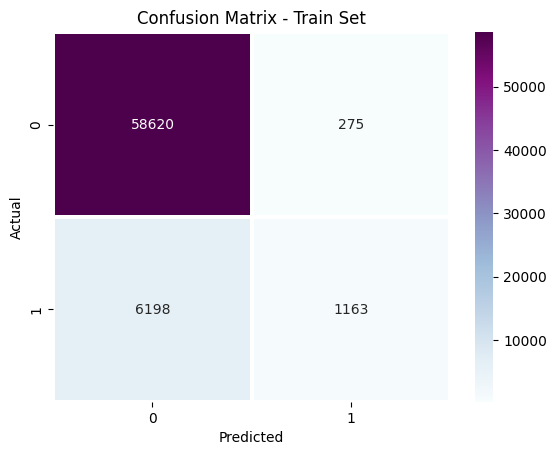

In [11]:
# Evaluate the model on training set
y_pred_train = xgb_model.predict(X_train)

# Confusion Matrix for Training Data
cm_train_xg = confusion_matrix(y_train, y_pred_train)
ax = sns.heatmap(cm_train_xg, annot=True, cmap='BuPu', fmt='g', linewidth=1.5)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Train Set')
plt.show()

## Test set

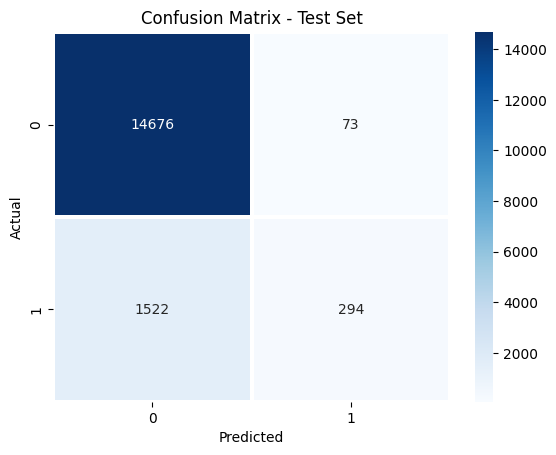

In [12]:
# Evaluate the model on test set
y_pred_test = xgb_model.predict(X_test)

# Confusion Matrix for Testig Data
cm_test_xgb = confusion_matrix(y_test, y_pred_test)
ax = sns.heatmap(cm_test_xgb, annot=True, cmap='Blues', fmt='g', linewidth=1.5)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Test Set')
plt.show()

In [13]:
# Number of goals in test set
print(f'The test dataset contains {len(y_test)} shots, with {y_test.sum()["is_goal"]} of them being goals.')

The test dataset contains 16565 shots, with 1816 of them being goals.


## Feature importance

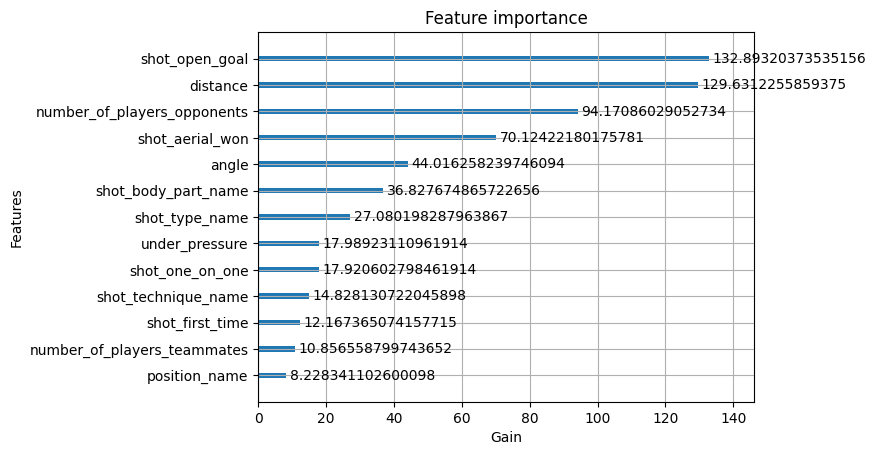

In [14]:
# Plot feature importance with Gain
xgboost.plot_importance(xgb_model, importance_type='gain', xlabel='Gain', max_num_features=20)
plt.show()

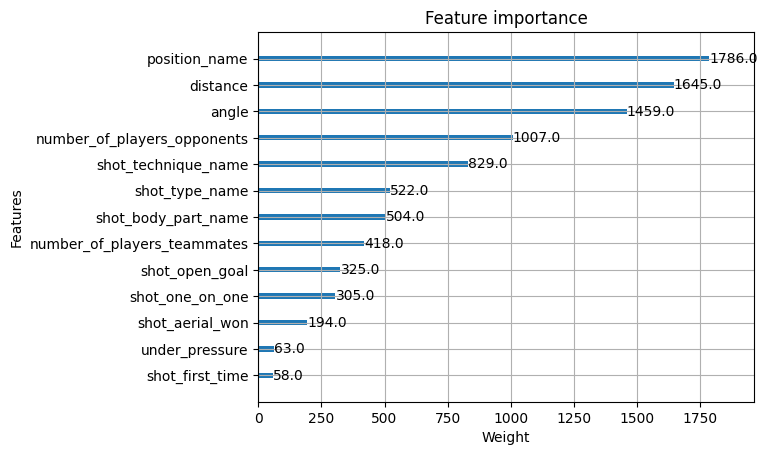

In [15]:
# Plot feature importance with Weight
xgboost.plot_importance(xgb_model, importance_type='weight', xlabel='Weight', max_num_features=30)
plt.show()

## Summary

In [19]:
# Calculating MAE, RMSE and R2 for training and test sets 
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

In [20]:
# Creating of dataframe of summary results
summary_df = pd.DataFrame({'Model Name':['XG Boost'],
                          'Training MAE': mae_train, 
                          'Training RMSE': rmse_train,
                          'Training R2':r2_train,
                          'Testing MAE': mae_test, 
                          'Testing RMSE': rmse_test,
                          'Testing R2':r2_test,
                          'Training Time (mins)': xgb_training_time/60})
summary_df.set_index('Model Name', inplace=True)

# Displaying summary of results
summary_df.style.format(precision =5).set_properties(**{'font-weight': 'bold',
            'border': '2.0px solid grey','color': 'white'})

,Training MAE,Training RMSE,Training R2,Testing MAE,Testing RMSE,Testing R2,Training Time (mins)
Model Name,,,,,,,
XG Boost,0.09770,0.09770,0.01073,0.09629,0.09629,0.01355,0.01710


# Keeping the xgboost model

In [21]:
# Save the model
xgb_model.save_model('xgboost.json')

xgb_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': True,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 300,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 1,
 'subsample': None,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None}

In [22]:
# Save the model
dump(xgb_model, 'xgboost.joblib') 

# # Load the model
model = load('xgboost.joblib')

In [28]:
xgb_model.predict_proba(X)

,position_name,shot_body_part_name,shot_technique_name,shot_type_name,shot_first_time,shot_one_on_one,shot_aerial_won,shot_open_goal,shot_follows_dribble,under_pressure,number_of_players_opponents,number_of_players_teammates,angle,distance,shot_kick_off
0,18,3,4,3,False,False,False,False,False,False,8,2,7.0,16.936647,False
1,18,1,4,3,False,False,False,False,False,False,9,4,27.0,12.580143,False
2,4,3,2,3,True,False,False,False,False,False,10,6,18.3,20.957099,False
3,10,3,4,3,False,False,False,False,False,False,10,5,32.8,12.180722,False
4,17,1,4,3,True,False,False,False,False,True,9,6,21.4,14.798986,False
